In [44]:
"""
Reference: https://www.drivendata.co/blog/predict-pm25-benchmark/

pyhdf appears to be more powerful than gdal, so it may be worth adopting some of the 
methods used here for working with hdf files.

Additionally, the tutorial shows how to make a masked numpy array, which allows us to work
with sparse arrays? (I'm not sure how this works yet.)

Finally, the tutorial explains how to align AOD data with coordinates. This could let us
make some useful model features, like local weather conditions, etc.

"""
# File manipulation
import os

# Pandas and Numpy
import numpy as np
import pandas as pd

# Date time manipulation
from datetime import datetime, timedelta
from dateutil import parser
import time

# Tensorflow/Keras
# import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras.backend as backend
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor

# SKlearn
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

# Matplotlib
import matplotlib.pyplot as plt

# Geo data processing
import geopandas as gpd
from pyhdf.SD import SD, SDC, SDS
import pyproj
from pyproj import CRS, Proj
from typing import Union
from shapely.geometry import Point, Polygon

# Pickle
import pickle

# PQDM for parallel procesing
from pqdm.processes import pqdm


In [2]:
# Inspect one dataset
hdf = SD(os.path.join('train', '20180201T191000_maiac_la_0.hdf'))

for field, data in hdf.datasets().items():
    print(field, "->", data)
    
print("")

blue_band_AOD = hdf.select("Optical_Depth_047")
name, num_dim, shape, types, num_attr = blue_band_AOD.info()
print(
f"""
Dataset name: {name}
Number of dimensions: {num_dim}
Shape: {shape}
Data type: {types}
Number of attributes: {num_attr}
"""
)

print("")

print(blue_band_AOD.get())

print("")

calibration_dict = blue_band_AOD.attributes()
print("Blue Band AOD Attributes:")
for key, value in calibration_dict.items():
    print(key, '->', value)

Optical_Depth_047 -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 0)
Optical_Depth_055 -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 1)
AOD_Uncertainty -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 2)
FineModeFraction -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 3)
Column_WV -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 4)
AOD_QA -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 23, 5)
AOD_MODEL -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 21, 6)
Injection_Height -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 5, 7)
cosSZA -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 22, 8)
cosVZA -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 22, 9)
RelAZ -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 2

In [3]:
raw_attr = hdf.attributes()["StructMetadata.0"] # Look at Metadata
print(raw_attr)
group_1 = raw_attr.split("END_GROUP=GRID_1")[0] # Pick out only 5km field in the metadata
# print(group_1)

hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])

# Parse expressions still wrapped in apostrophes
for key, val in hdf_metadata.items():
    try:
        hdf_metadata[key] = eval(val)
    except (NameError, ValueError, SyntaxError):
        hdf_metadata[key] = val

for key, value in hdf_metadata.items():
    print(key, '->', value)

print("")
    
# Note that coordinates are provided in meters
# We construct an alignment dictionary parameter
alignment_dict = {
    "upper_left": hdf_metadata["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata["LowerRightMtrs"],
    "crs": hdf_metadata["Projection"],
    "crs_params": hdf_metadata["ProjParams"]
}

for key, value in alignment_dict.items():
    print(key, '->', value)


GROUP=SwathStructure
END_GROUP=SwathStructure
GROUP=GridStructure
	GROUP=GRID_1
		GridName="grid1km"
		XDim=1200
		YDim=1200
		UpperLeftPointMtrs=(-11119505.196667,4447802.078667)
		LowerRightMtrs=(-10007554.677000,3335851.559000)
		Projection=GCTP_SNSOID
		ProjParams=(6371007.181000,0,0,0,0,0,0,0,0,0,0,0,0)
		SphereCode=-1
		GridOrigin=HDFE_GD_UL
		GROUP=Dimension
			OBJECT=Dimension_1
				DimensionName="Orbits"
				Size=4
			END_OBJECT=Dimension_1
		END_GROUP=Dimension
		GROUP=DataField
			OBJECT=DataField_1
				DataFieldName="Optical_Depth_047"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_1
			OBJECT=DataField_2
				DataFieldName="Optical_Depth_055"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_2
			OBJECT=DataField_3
				DataFieldName="AOD_Uncertainty"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_3
			OBJECT=DataField_4
				DataFieldName="FineModeFraction"
				Data

In [4]:
##################
#DATA PROCESSING #
##################
# Loop over orbits to apply the attributes
def calibrate_data(dataset, shape, calibration_dict):
    """
    Given a MAIAC dataset and calibration parameters, return a masked
    array of calibrated data.
    
    Args:
        dataset (SDS): dataset in SDS format (e.g. blue band AOD).
        shape (List[int]): dataset shape as a list of [orbits, height, width].
        calibration_dict (Dict): dictionary containing, at a minimum,
            `valid_range` (list or tuple), `_FillValue` (int or float),
            `add_offset` (float), and `scale_factor` (float).
    
    Returns:
        corrected_AOD (np.ma.MaskedArray): masked array of calibrated data
            with a fill value of nan.
    """
    corrected_AOD = np.ma.empty(shape, dtype=np.double)
    for orbit in range(shape[0]):
        data = dataset[orbit, :, :].astype(np.double)
        invalid_condition = (
            (data < calibration_dict["valid_range"][0]) |
            (data > calibration_dict["valid_range"][1]) |
            (data == calibration_dict["_FillValue"])
        )
        data[invalid_condition] = np.nan
        if 'add_offset' not in calibration_dict:
            offset = 0
        else:
            offset = calibration_dict["add_offset"]
        if 'scale_factor' not in calibration_dict:
            scale_factor = 1
        else:
            scale_factor = calibration_dict["scale_factor"]
        data = (
            (data - offset) *
            scale_factor
        )
        data = np.ma.masked_array(data, np.isnan(data))
        corrected_AOD[orbit, : :] = data
    corrected_AOD.fill_value = np.nan
    return corrected_AOD

In [5]:
# Test calibrate_data function
corrected_AOD = calibrate_data(blue_band_AOD, shape, calibration_dict)
print(corrected_AOD)
print(pd.DataFrame(corrected_AOD.ravel(), columns=['AOD']).describe())

[[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [0.021 0.021 0.021 ... -- -- --]
  [0.022 0.021 0.021 ... -- -- --]
  [0.024 0.022 0.021 ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [0.073 0.065 0.053 ... -- -- --]
  [0.062 0.057 0.051000000000000004 ... -- -- --]
  [0.056 0.048 0.041 ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]]
                AOD
count  1.203568e+06
mean   9.204344e-02
std    6.629422e-02
min    0.000000e+00
25%    4.500000e-02
50%    7.200000e-02
75%    1.220000e-01
max    5.940000e-01


In [6]:
# Aligning AOD data with real world coordinates
def create_meshgrid(alignment_dict, shape):
    """Given an image shape, create a meshgrid of points
    between bounding coordinates.
    
    Args:
        alignment_dict (Dict): dictionary containing, at a minimum,
            `upper_left` (tuple), `lower_right` (tuple), `crs` (str),
            and `crs_params` (tuple).
        shape (List[int]): dataset shape as a list of
            [orbits, height, width].
    
    Returns:
        xv (np.array): x (longitude) coordinates.
        yv (np.array): y (latitude) coordinates.
    """
    # Determine grid bounds using two coordinates
    x0, y0 = alignment_dict["upper_left"]
    x1, y1 = alignment_dict["lower_right"]
    
    # Interpolate points between corners, inclusive of bounds
    x = np.linspace(x0, x1, shape[2], endpoint=True)
    y = np.linspace(y0, y1, shape[1], endpoint=True)
    
    # Return two 2D arrays representing X & Y coordinates of all points
    xv, yv = np.meshgrid(x, y)
    return xv, yv

xv, yv = create_meshgrid(alignment_dict, shape)
print(xv, yv)

[[-11119505.196667   -11118577.79840206 -11117650.40013711 ...
  -10009409.47352989 -10008482.07526494 -10007554.677     ]
 [-11119505.196667   -11118577.79840206 -11117650.40013711 ...
  -10009409.47352989 -10008482.07526494 -10007554.677     ]
 [-11119505.196667   -11118577.79840206 -11117650.40013711 ...
  -10009409.47352989 -10008482.07526494 -10007554.677     ]
 ...
 [-11119505.196667   -11118577.79840206 -11117650.40013711 ...
  -10009409.47352989 -10008482.07526494 -10007554.677     ]
 [-11119505.196667   -11118577.79840206 -11117650.40013711 ...
  -10009409.47352989 -10008482.07526494 -10007554.677     ]
 [-11119505.196667   -11118577.79840206 -11117650.40013711 ...
  -10009409.47352989 -10008482.07526494 -10007554.677     ]] [[4447802.078667   4447802.078667   4447802.078667   ... 4447802.078667
  4447802.078667   4447802.078667  ]
 [4446874.68040206 4446874.68040206 4446874.68040206 ... 4446874.68040206
  4446874.68040206 4446874.68040206]
 [4445947.28213711 4445947.28213711 

In [7]:
# Source: https://spatialreference.org/ref/sr-org/modis-sinusoidal/proj4js/
sinu_crs = Proj(f"+proj=sinu +R={alignment_dict['crs_params'][0]} +nadgrids=@null +wktext").crs
wgs84_crs = CRS.from_epsg("4326")

def transform_arrays(
    xv: Union[np.array, float],
    yv: Union[np.array, float],
    crs_from: CRS,
    crs_to: CRS
):
    """Transform points or arrays from one CRS to another CRS.
    
    Args:
        xv (np.array or float): x (longitude) coordinates or value.
        yv (np.array or float): y (latitude) coordinates or value.
        crs_from (CRS): source coordinate reference system.
        crs_to (CRS): destination coordinate reference system.
    
    Returns:
        lon, lat (tuple): x coordinate(s), y coordinate(s)
    """
    transformer = pyproj.Transformer.from_crs(
        crs_from,
        crs_to,
        always_xy=True,
    )
    lon, lat = transformer.transform(xv, yv)
    return lon, lat

# Project sinu grid onto wgs84 grid
lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)
print(lon, lat)

[[-130.54072891 -130.52984145 -130.51895398 ... -117.50843096
  -117.49754349 -117.48665602]
 [-130.52478749 -130.51390136 -130.50301522 ... -117.49408102
  -117.48319488 -117.47230874]
 [-130.50885273 -130.49796792 -130.48708311 ... -117.47973707
  -117.46885227 -117.45796746]
 ...
 [-115.4894707  -115.47983855 -115.4702064  ... -103.95978793
  -103.95015578 -103.94052363]
 [-115.47976022 -115.47012888 -115.46049755 ... -103.95104688
  -103.94141554 -103.9317842 ]
 [-115.47005382 -115.46042329 -115.45079276 ... -103.9423095
  -103.93267897 -103.92304844]] [[40.         40.         40.         ... 40.         40.
  40.        ]
 [39.99165971 39.99165971 39.99165971 ... 39.99165971 39.99165971
  39.99165971]
 [39.98331943 39.98331943 39.98331943 ... 39.98331943 39.98331943
  39.98331943]
 ...
 [30.01668056 30.01668056 30.01668056 ... 30.01668056 30.01668056
  30.01668056]
 [30.00834028 30.00834028 30.00834028 ... 30.00834028 30.00834028
  30.00834028]
 [30.         30.         30.      

In [8]:
def convert_array_to_df(
    corrected_arr,
    lat,
    lon,
    granule_id,
    crs,
    total_bounds = None
):
    """Align data values with latitude and longitude coordinates
    and return a GeoDataFrame.
    
    Args:
        corrected_arr (np.ma.MaskedArray): data values for each pixel.
        lat (np.ndarray): latitude for each pixel.
        lon (np.ndarray): longitude for each pixel.
        granule_id (str): granule name.
        crs (CRS): coordinate reference system
        total_bounds (np.ndarray, optional): If provided,
            will filter out points that fall outside of these bounds.
            Composed of xmin, ymin, xmax, ymax.
    """
    lats = lat.ravel()
    lons = lon.ravel()
    n_orbits = len(corrected_arr)
    size = lats.size
    values = {
        "value": np.concatenate([d.data.ravel() for d in corrected_arr]),
        "lat": np.tile(lats, n_orbits),
        "lon": np.tile(lons, n_orbits),
        "orbit": np.arange(n_orbits).repeat(size),
        "granule_id": [granule_id] * size * n_orbits
        
    }
    
    df = pd.DataFrame(values).dropna()
    if total_bounds is not None:
        x_min, y_min, x_max, y_max = total_bounds
        df = df[df.lon.between(x_min, x_max) & df.lat.between(y_min, y_max)]
    
    gdf = gpd.GeoDataFrame(df)
    gdf["geometry"] = gpd.points_from_xy(gdf.lon, gdf.lat)
    gdf.crs = crs
    return gdf[["granule_id", "orbit", "geometry", "value"]].reset_index(drop=True)

def plot_gdf(gdf, separate_bands=True, title='Blue Band AOD'):
    """Plot the Point objects contained in a GeoDataFrame.
    Option to overlay bands.
    
    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame with, at a minimum,
            columns for `orbit`, `geometry`, and `value`.
        separate_bands (bool): Plot each band on its own axis.
            Defaults to True.
    
    Displays a matplotlib scatterplot.
    """
    if separate_bands:
        num_orbits = gdf.orbit.max() + 1
        f, axes = plt.subplots(
            1,
            num_orbits,
            figsize=(20, 5),
            sharex=True,
            sharey=True
        )
        for i, ax in enumerate(axes):
            gdf_orbit = gdf[gdf.orbit == i]
            img = ax.scatter(
                x=gdf_orbit.geometry.x,
                y=gdf_orbit.geometry.y,
                c=gdf_orbit.value,
                s=0.1,
                alpha=1,
                cmap="RdYlBu_r"
            )
            ax.set_title(f"Band {i + 1}", fontsize=12)
    else:
        f, ax = plt.subplots(1, 1, figsize=(4, 4))
        img = ax.scatter(
            x=gdf.geometry.x,
            y=gdf.geometry.y,
            c=gdf.value,
            s=0.15,
            alpha=1,
            cmap="RdYlBu_r"
        )
    f.colorbar(img)
    plt.suptitle(title, fontsize=12)

In [9]:
# def compute_affine_transform(x0, x1, y0, y1, height, width):
#     """Given bounding coordinates and resolution, compute
#     the affine transformation.
    
#     Args:
#         x0 (float): left coordinate.
#         x1 (float): right coordinate.
#         y0 (float): top coordinate.
#         y1 (float): bottom coordinate.
#         height (int): image height.
#         width (int): image width.

#     Returns:
#         affine_transform (Affine): Affine transformation.
#     """
#     affine_transform = rasterio.transform.from_bounds(
#         west=x0,
#         south=y1,
#         east=x1,
#         north=y0,
#         height=height,
#         width=width
#     )
#     return affine_transform

(1203568, 4)
                       granule_id  orbit                     geometry  value
0  20180201T191000_maiac_la_0.hdf      0  POINT (-110.79078 35.36280)  0.110
1  20180201T191000_maiac_la_0.hdf      0  POINT (-110.78956 35.35446)  0.076
2  20180201T191000_maiac_la_0.hdf      0  POINT (-110.28947 35.28774)  0.112


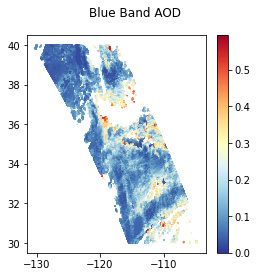

In [10]:
gdf = convert_array_to_df(corrected_AOD, lat, lon, '20180201T191000_maiac_la_0.hdf', wgs84_crs)
print(gdf.shape)
print(gdf.head(3))

plot_gdf(gdf, separate_bands=False)

In [11]:
# Some more helpful functions from the tutorial
def create_calibration_dict(data):
    """Define calibration dictionary given a SDS dataset,
    which contains:
        - name
        - scale factor
        - offset
        - unit
        - fill value
        - valid range
    
    Args:
        data (SDS): dataset in the SDS format.
    
    Returns:
        calibration_dict (Dict): dict of calibration parameters.
    """
    return data.attributes()

def create_alignment_dict(hdf):
    """Define alignment dictionary given a SD data file, 
    which contains:
        - upper left coordinates
        - lower right coordinates
        - coordinate reference system (CRS)
        - CRS parameters
    
    Args:
        hdf (SD): hdf data object
    
    Returns:
        alignment_dict (Dict): dict of alignment parameters.
    """
    group_1 = hdf.attributes()["StructMetadata.0"].split("END_GROUP=GRID_1")[0]
    hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])
    alignment_dict = {
        "upper_left": eval(hdf_metadata["UpperLeftPointMtrs"]),
        "lower_right": eval(hdf_metadata["LowerRightMtrs"]),
        "crs": hdf_metadata["Projection"],
        "crs_params": hdf_metadata["ProjParams"]
    }
    return alignment_dict

In [12]:
# pm_md = pd.read_csv("pm25_satellite_metadata.csv", parse_dates=["time_start", "time_end"], index_col=0)
# grid_md = pd.read_csv("grid_metadata.csv", index_col=0)
# maiac_md = pm_md[(pm_md["product"] == "maiac") & (pm_md["split"] == "train")].copy()

In [13]:
# Importing HDF data and creating a set of raw hdf files.
train_labels = pd.read_csv("train_labels.csv")
train_labels['Date'] = pd.to_datetime(train_labels['datetime'], format='%Y-%m-%d')
train_labels['Year'] = train_labels['Date'].dt.year
grid_metadata = pd.read_csv("grid_metadata.csv")
satellite_metadata = pd.read_csv("pm25_satellite_metadata.csv")
satellite_metadata['Date'] =  pd.to_datetime(satellite_metadata['time_end'], format='%Y-%m-%d')

la_gc = grid_metadata[grid_metadata['location'] == "Los Angeles (SoCAB)"].copy()
dl_gc = grid_metadata[grid_metadata['location'] == "Delhi"].copy()
tp_gc = grid_metadata[grid_metadata['location'] == "Taipei"].copy()

# Confirm all LA, Taipei, Delhi grid cells are in our training labels
assert la_gc['grid_id'].isin(train_labels.grid_id).all()
assert dl_gc['grid_id'].isin(train_labels.grid_id).all()
assert tp_gc['grid_id'].isin(train_labels.grid_id).all()

print("LA Grid Len:", len(la_gc))
print("Delhi Grid Len:", len(dl_gc))
print("Taipei Grid Len:", len(tp_gc))

print(train_labels.head(n=10))

# satellite_metadata = satellite_metadata[satellite_metadata.granule_id.str.endswith('f')]
# satellite_metadata = satellite_metadata[satellite_metadata['split'] == 'train']
# print(satellite_metadata)
# raw_hdf_set = set(satellite_metadata['granule_id'])

LA Grid Len: 14
Delhi Grid Len: 33
Taipei Grid Len: 7
               datetime grid_id  value                      Date  Year
0  2018-02-01T08:00:00Z   3S31A   11.4 2018-02-01 08:00:00+00:00  2018
1  2018-02-01T08:00:00Z   A2FBI   17.0 2018-02-01 08:00:00+00:00  2018
2  2018-02-01T08:00:00Z   DJN0F   11.1 2018-02-01 08:00:00+00:00  2018
3  2018-02-01T08:00:00Z   E5P9N   22.1 2018-02-01 08:00:00+00:00  2018
4  2018-02-01T08:00:00Z   FRITQ   29.8 2018-02-01 08:00:00+00:00  2018
5  2018-02-01T08:00:00Z   H96P6   12.8 2018-02-01 08:00:00+00:00  2018
6  2018-02-01T08:00:00Z   PG3MI   21.0 2018-02-01 08:00:00+00:00  2018
7  2018-02-01T08:00:00Z   QJHW4    5.2 2018-02-01 08:00:00+00:00  2018
8  2018-02-01T08:00:00Z   WT52R    6.5 2018-02-01 08:00:00+00:00  2018
9  2018-02-01T08:00:00Z   X5DKW   17.7 2018-02-01 08:00:00+00:00  2018


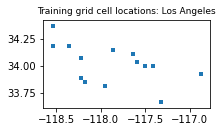

In [14]:
la_polys = gpd.GeoSeries.from_wkt(la_gc.wkt, crs=wgs84_crs) # used for WGS 84
la_polys.name = "geometry"
la_polys_gdf = gpd.GeoDataFrame(la_polys)

la_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Los Angeles", fontsize=9);

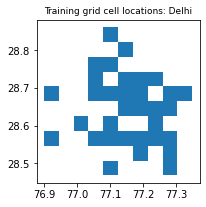

In [15]:
dl_polys = gpd.GeoSeries.from_wkt(dl_gc.wkt, crs=wgs84_crs) # used for WGS 84
dl_polys.name = "geometry"
dl_polys_gdf = gpd.GeoDataFrame(dl_polys)

dl_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Delhi", fontsize=9);

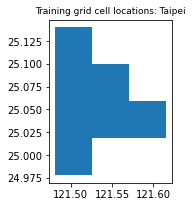

In [16]:
tp_polys = gpd.GeoSeries.from_wkt(tp_gc.wkt, crs=wgs84_crs) # used for WGS 84
tp_polys.name = "geometry"
tp_polys_gdf = gpd.GeoDataFrame(tp_polys)

tp_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Taipei", fontsize=9);

In [17]:
# For pqdm if necessary
# !jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [23]:
# We split train_labels into train and cross validation

train_actual_labels = train_labels[train_labels['Year'] <= 2019].copy()
train_cross_val_labels = train_labels[train_labels['Year'] > 2019].copy()

# print(len(train_actual_labels.index))
# print(len(train_cross_val_labels.index))

# We randomly pick a few training data points to test the feature generation algorithm
n = 100
train_labels_subset = train_actual_labels.sample(n=n).copy()

def get_grid_data(metadata, grid_id):
    return metadata[metadata["grid_id"] == grid_id]

def fetch_satellite_meta(metadata, date_time, location, datatype, split):
    if location == "Delhi":
        location = "dl"
    elif location == "Taipei":
        location = "tpe"
    else:
        location = "la"

    metadata = metadata[metadata['location'] == location]
    metadata = metadata[metadata['product'] == datatype]
    metadata = metadata[metadata['split'] == split]
    dateobject = parser.parse(date_time)
    return metadata.loc[(metadata['Date'].dt.month == dateobject.month) & 
                        (metadata['Date'].dt.day == dateobject.day) &
                        (metadata['Date'].dt.year <= dateobject.year)]

def fetch_granule_id(grid_id, date_time, split):
    temp = get_grid_data(grid_metadata, grid_id)
    location = temp.iloc[0]['location']
    sat_met = fetch_satellite_meta(satellite_metadata, 
                               date_time, 
                               location, 
                               "maiac", 
                               split)
    granule_ids = []
    for i in range(len(sat_met)):
        granule_id = sat_met.iloc[i]['granule_id']
        granule_ids.append(granule_id)
            
    return granule_ids, location

def fetch_alignment_dictionary(hdf, field_name):
    raw_attr = hdf.attributes()["StructMetadata.0"]  # Look at Metadata
    text_array = raw_attr.split("END_GROUP=GRID_1")  # The alignment values are always the same for a given HDF
    
#     second_array = text_array[1].split("END_GROUP=GRID_2")
#     text_array.pop()
#     text_array.extend(second_array)
    
#     option = 0
#     for idx, text in enumerate(text_array):
#         if field_name in text:
#             option = idx
#             break
    
    group_1 = text_array[0]
    hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])

    # Parse expressions still wrapped in apostrophes
    for key, val in hdf_metadata.items():
        try:
            hdf_metadata[key] = eval(val)
        except (NameError, ValueError, SyntaxError):
            hdf_metadata[key] = val

            
    # Note that coordinates are provided in meters
    # We construct an alignment dictionary parameter
    alignment_dict = {
        "upper_left": hdf_metadata["UpperLeftPointMtrs"],
        "lower_right": hdf_metadata["LowerRightMtrs"],
        "crs": hdf_metadata["Projection"],
        "crs_params": hdf_metadata["ProjParams"]
    }
    
    return alignment_dict

def preprocess_maiac_data(granule_id, location, split, field_name):
    # print(granule_id, location, split, field_name)
    hdf = SD(os.path.join(split, granule_id))
    field = hdf.select(field_name)
    name, num_dim, shape, types, num_attr = field.info()
    if field_name in ['AOD_QA']:
        corrected_field = field
    else:
        calibration_dict = field.attributes()
        corrected_field = calibrate_data(field, shape, calibration_dict)
    alignment_dict = fetch_alignment_dictionary(hdf, field_name)
    xv, yv = create_meshgrid(alignment_dict, shape)
    sinu_crs = Proj(f"+proj=sinu +R={alignment_dict['crs_params'][0]} +nadgrids=@null +wktext").crs
    wgs84_crs = CRS.from_epsg("4326")
    lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)
    
    if location == "Delhi":
        polys = gpd.GeoSeries.from_wkt(dl_gc.wkt, crs=wgs84_crs)
    elif location == "Taipei":
        polys = gpd.GeoSeries.from_wkt(tp_gc.wkt, crs=wgs84_crs)
    else:
        polys = gpd.GeoSeries.from_wkt(la_gc.wkt, crs=wgs84_crs)
    
    polys.name = "geometry"
    polys_gdf = gpd.GeoDataFrame(polys)
    
    # xmin, ymin, xmax, ymax = polys_gdf.total_bounds
    gdf = convert_array_to_df(corrected_field, lat, lon, granule_id, wgs84_crs, polys_gdf.total_bounds)
    
    df = gpd.sjoin(polys_gdf, gdf, how="inner")
    
    hdf.end()
    
    return df.drop(columns="index_right").reset_index()

# Parallelize processes
# def preprocess_field_parallel(args, n_jobs=2):
#     args_sub = args[:2]
#     print(args_sub)
#     results = pqdm(args_sub, preprocess_maiac_data, n_jobs=n_jobs, argument_type="args")
#     return pd.concat(results)

def generate_features(train_labels, split="train"):
    labels = []
    features = []
    args = []
    
    print("Length train_labels:", len(train_labels.index))
    for idx, i in enumerate(train_labels.index): 
        granule_ids, location = fetch_granule_id(train_labels.loc[i]['grid_id'], train_labels.loc[i]['datetime'], split)
    
        blueband_dataframe_list = []
        greenband_dataframe_list = []
        aod_uncertainty_dataframe_list = []
        finemodefraction_dataframe_list = []
        column_wv_dataframe_list = []
        injection_height_dataframe_list = []
#         aod_qa_dataframe_list = []
        
        for granule_id in granule_ids:
            result_blueband = preprocess_maiac_data(*[granule_id, location, split, 'Optical_Depth_047'])
            result_greenband = preprocess_maiac_data(*[granule_id, location, split, 'Optical_Depth_055'])
            result_aod_uncertainty = preprocess_maiac_data(*[granule_id, location, split, 'AOD_Uncertainty'])
            result_finemodefraction = preprocess_maiac_data(*[granule_id, location, split, 'FineModeFraction'])
            result_column_wv = preprocess_maiac_data(*[granule_id, location, split, 'Column_WV'])
            result_injection_height = preprocess_maiac_data(*[granule_id, location, split, 'Injection_Height'])
#             result_aod_qa = preprocess_maiac_data(*[granule_id, location, split, 'AOD_QA'])
            
            blueband_dataframe_list.append(result_blueband)
            greenband_dataframe_list.append(result_greenband)
            aod_uncertainty_dataframe_list.append(result_aod_uncertainty)
            finemodefraction_dataframe_list.append(result_finemodefraction)
            column_wv_dataframe_list.append(result_column_wv)
            injection_height_dataframe_list.append(result_injection_height)
#             aod_qa_dataframe_list.append(result_aod_qa)
        
        combined_blueband_df = pd.concat(blueband_dataframe_list)
        combined_greenband_df = pd.concat(greenband_dataframe_list)
        combined_aod_uncertainty_df = pd.concat(aod_uncertainty_dataframe_list)
        combined_finemodefraction_df = pd.concat(finemodefraction_dataframe_list)
        combined_column_wv_df = pd.concat(column_wv_dataframe_list)
        combined_injection_height_df = pd.concat(injection_height_dataframe_list)
#         combined_aod_qa_df = pd.concat(aod_qa_dataframe_list)
        
        feature = []
        # Order of statistics: min, max, mean
        if combined_blueband_df.empty:
            feature.extend([np.nan, np.nan, np.nan])
        else:
            feature.extend([combined_blueband_df['value'].min(), combined_blueband_df['value'].max(), 
                            combined_blueband_df['value'].mean()]) 
        
        if combined_greenband_df.empty:
            feature.extend([np.nan, np.nan, np.nan])
        else:
            feature.extend([combined_greenband_df['value'].min(), combined_greenband_df['value'].max(), 
                            combined_greenband_df['value'].mean()]) 
        
        if combined_aod_uncertainty_df.empty:
            feature.extend([np.nan, np.nan, np.nan])
        else:
            feature.extend([combined_aod_uncertainty_df['value'].min(), combined_aod_uncertainty_df['value'].max(), 
                            combined_aod_uncertainty_df['value'].mean()])
            
        if combined_finemodefraction_df.empty:
            feature.extend([np.nan, np.nan, np.nan])
        else:
            feature.extend([combined_finemodefraction_df['value'].min(), combined_finemodefraction_df['value'].max(), 
                            combined_finemodefraction_df['value'].mean()])
            
        if combined_column_wv_df.empty:
            feature.extend([np.nan, np.nan, np.nan])
        else:
            feature.extend([combined_column_wv_df['value'].min(), combined_column_wv_df['value'].max(), 
                            combined_column_wv_df['value'].mean()])
        
        if combined_injection_height_df.empty:
            feature.extend([np.nan, np.nan, np.nan])
        else:
            feature.extend([combined_injection_height_df['value'].min(), combined_injection_height_df['value'].max(), 
                            combined_injection_height_df['value'].mean()])
        
#         if combined_aod_qa_df.empty:
#             feature.extend([np.nan, np.nan, np.nan])
#         else:
#             feature.extend([combined_aod_qa_df['value'].min(), combined_aod_qa_df['value'].max(), 
#                             combined_aod_qa_df['value'].mean()])
        
        label = train_labels.loc[i]['value']
        features.append(feature)
        labels.append(label)
        
    return features, labels

startTime = time.time()
features, labels = generate_features(train_labels_subset, "train")
endTime = time.time()
elapsedTime = endTime - startTime
print("Elapsed time: {}".format(str(timedelta(seconds=elapsedTime))))

print("Features")
print(features)
print("Labels")
print(labels)

Length train_labels: 100
Features
[[1.621, 4.0, 2.1512543554006958, 1.319, 3.2760000000000002, 1.7577909407665497, 0.017400000000000002, 0.4207, 0.0844651809651473, nan, nan, nan, 0.1, 5.585, 2.3015056625141534, nan, nan, nan], [nan, nan, nan, nan, nan, nan, 0.014400000000000001, 0.30910000000000004, 0.06792389410187687, nan, nan, nan, 0.1, 4.902, 1.70485053619303, nan, nan, nan], [0.02, 0.354, 0.13102119460500955, 0.014, 0.262, 0.09679150579150585, 0.0159, 0.20520000000000002, 0.07000531135531135, nan, nan, nan, 0.9500000000000001, 1.974, 1.450711433756806, nan, nan, nan], [0.146, 0.919, 0.5355943935926774, 0.112, 0.734, 0.42015045766590375, 0.0227, 0.3201, 0.07772932305630043, nan, nan, nan, 0.21, 2.72, 2.008017767348312, nan, nan, nan], [0.026000000000000002, 0.427, 0.18913235294117653, 0.019, 0.316, 0.1398823529411765, 0.006, 0.10840000000000001, 0.02953457350272231, nan, nan, nan, 0.093, 2.248, 0.635812442817938, nan, nan, nan], [0.261, 1.688, 0.7991868556701026, 0.201, 1.374, 0.6

In [35]:
features_array = np.asarray(features)
labels_array = np.asarray(labels)

# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# imputed_features = imp.fit_transform(features_array)

imp_mean = IterativeImputer(random_state=0)
imputed_features = imp_mean.fit_transform(features_array)

trans = MinMaxScaler()
features_array_transform = trans.fit_transform(imputed_features)

print(features)
print(imputed_features)
print(imputed_features.shape)
print(labels_array.shape)

[[1.621, 4.0, 2.1512543554006958, 1.319, 3.2760000000000002, 1.7577909407665497, 0.017400000000000002, 0.4207, 0.0844651809651473, nan, nan, nan, 0.1, 5.585, 2.3015056625141534, nan, nan, nan], [nan, nan, nan, nan, nan, nan, 0.014400000000000001, 0.30910000000000004, 0.06792389410187687, nan, nan, nan, 0.1, 4.902, 1.70485053619303, nan, nan, nan], [0.02, 0.354, 0.13102119460500955, 0.014, 0.262, 0.09679150579150585, 0.0159, 0.20520000000000002, 0.07000531135531135, nan, nan, nan, 0.9500000000000001, 1.974, 1.450711433756806, nan, nan, nan], [0.146, 0.919, 0.5355943935926774, 0.112, 0.734, 0.42015045766590375, 0.0227, 0.3201, 0.07772932305630043, nan, nan, nan, 0.21, 2.72, 2.008017767348312, nan, nan, nan], [0.026000000000000002, 0.427, 0.18913235294117653, 0.019, 0.316, 0.1398823529411765, 0.006, 0.10840000000000001, 0.02953457350272231, nan, nan, nan, 0.093, 2.248, 0.635812442817938, nan, nan, nan], [0.261, 1.688, 0.7991868556701026, 0.201, 1.374, 0.6384304123711341, 0.0085, 0.1438, 0

In [36]:
def flat_dense_model():  
    model = Sequential()
    model.add(Dense(15, activation='relu', input_shape=(15,)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = flat_dense_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 6         
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [37]:
print(type(features_array_transform))
print(type(labels_array))

# For testing
history = model.fit(features_array_transform, labels_array, epochs=2500, batch_size=20)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch 1/2500
5/5 [==============================] - 0s 1ms/step - loss: 13469.1826
Epoch 2/2500
5/5 [==============================] - 0s 999us/step - loss: 13467.5312
Epoch 3/2500
5/5 [==============================] - 0s 1ms/step - loss: 13465.5342
Epoch 4/2500
5/5 [==============================] - 0s 1ms/step - loss: 13463.2734
Epoch 5/2500
5/5 [==============================] - 0s 799us/step - loss: 13460.3252
Epoch 6/2500
5/5 [==============================] - 0s 995us/step - loss: 13457.5723
Epoch 7/2500
5/5 [==============================] - 0s 804us/step - loss: 13454.1250
Epoch 8/2500
5/5 [==============================] - 0s 804us/step - loss: 13450.4805
Epoch 9/2500
5/5 [==============================] - 0s 995us/step - loss: 13446.4766
Epoch 10/2500
5/5 [==============================] - 0s 800us/step - loss: 13442.4805
Epoch 11/2500
5/5 [==============================] - 0s 1ms/step - loss: 13437.7842
Epoch 12/2500
5/5 [====

5/5 [==============================] - 0s 600us/step - loss: 8503.1689
Epoch 97/2500
5/5 [==============================] - 0s 603us/step - loss: 8489.1445
Epoch 98/2500
5/5 [==============================] - 0s 600us/step - loss: 8465.6641
Epoch 99/2500
5/5 [==============================] - 0s 600us/step - loss: 8446.1396
Epoch 100/2500
5/5 [==============================] - 0s 600us/step - loss: 8425.1904
Epoch 101/2500
5/5 [==============================] - 0s 600us/step - loss: 8408.5342
Epoch 102/2500
5/5 [==============================] - 0s 600us/step - loss: 8387.7148
Epoch 103/2500
5/5 [==============================] - 0s 800us/step - loss: 8369.8887
Epoch 104/2500
5/5 [==============================] - 0s 800us/step - loss: 8351.5146
Epoch 105/2500
5/5 [==============================] - 0s 800us/step - loss: 8331.0410
Epoch 106/2500
5/5 [==============================] - 0s 800us/step - loss: 8313.4512
Epoch 107/2500
5/5 [==============================] - 0s 600us/step - lo

5/5 [==============================] - 0s 600us/step - loss: 6495.2485
Epoch 192/2500
5/5 [==============================] - 0s 600us/step - loss: 6475.2412
Epoch 193/2500
5/5 [==============================] - 0s 600us/step - loss: 6458.2090
Epoch 194/2500
5/5 [==============================] - 0s 599us/step - loss: 6441.6455
Epoch 195/2500
5/5 [==============================] - 0s 600us/step - loss: 6425.0952
Epoch 196/2500
5/5 [==============================] - 0s 600us/step - loss: 6406.3032
Epoch 197/2500
5/5 [==============================] - 0s 599us/step - loss: 6385.8286
Epoch 198/2500
5/5 [==============================] - 0s 800us/step - loss: 6368.6152
Epoch 199/2500
5/5 [==============================] - 0s 600us/step - loss: 6352.1777
Epoch 200/2500
5/5 [==============================] - 0s 600us/step - loss: 6336.8667
Epoch 201/2500
5/5 [==============================] - 0s 596us/step - loss: 6323.0098
Epoch 202/2500
5/5 [==============================] - 0s 600us/step -

5/5 [==============================] - 0s 600us/step - loss: 4911.0986
Epoch 287/2500
5/5 [==============================] - 0s 600us/step - loss: 4897.3306
Epoch 288/2500
5/5 [==============================] - 0s 800us/step - loss: 4883.6392
Epoch 289/2500
5/5 [==============================] - 0s 600us/step - loss: 4869.9395
Epoch 290/2500
5/5 [==============================] - 0s 800us/step - loss: 4849.7988
Epoch 291/2500
5/5 [==============================] - 0s 598us/step - loss: 4835.6982
Epoch 292/2500
5/5 [==============================] - 0s 601us/step - loss: 4819.1904
Epoch 293/2500
5/5 [==============================] - 0s 600us/step - loss: 4803.5894
Epoch 294/2500
5/5 [==============================] - 0s 600us/step - loss: 4788.3989
Epoch 295/2500
5/5 [==============================] - 0s 600us/step - loss: 4774.7666
Epoch 296/2500
5/5 [==============================] - 0s 600us/step - loss: 4759.4448
Epoch 297/2500
5/5 [==============================] - 0s 600us/step -

5/5 [==============================] - 0s 599us/step - loss: 3572.4312
Epoch 382/2500
5/5 [==============================] - 0s 600us/step - loss: 3561.0283
Epoch 383/2500
5/5 [==============================] - 0s 604us/step - loss: 3550.0925
Epoch 384/2500
5/5 [==============================] - 0s 600us/step - loss: 3539.1265
Epoch 385/2500
5/5 [==============================] - 0s 600us/step - loss: 3529.4519
Epoch 386/2500
5/5 [==============================] - 0s 600us/step - loss: 3519.7051
Epoch 387/2500
5/5 [==============================] - 0s 600us/step - loss: 3503.2490
Epoch 388/2500
5/5 [==============================] - 0s 600us/step - loss: 3493.8484
Epoch 389/2500
5/5 [==============================] - 0s 600us/step - loss: 3484.6304
Epoch 390/2500
5/5 [==============================] - 0s 599us/step - loss: 3477.7234
Epoch 391/2500
5/5 [==============================] - 0s 600us/step - loss: 3464.0293
Epoch 392/2500
5/5 [==============================] - 0s 600us/step -

5/5 [==============================] - 0s 600us/step - loss: 2754.5913
Epoch 477/2500
5/5 [==============================] - 0s 600us/step - loss: 2749.6917
Epoch 478/2500
5/5 [==============================] - 0s 600us/step - loss: 2747.3997
Epoch 479/2500
5/5 [==============================] - 0s 600us/step - loss: 2746.5867
Epoch 480/2500
5/5 [==============================] - 0s 599us/step - loss: 2729.9685
Epoch 481/2500
5/5 [==============================] - 0s 600us/step - loss: 2723.8601
Epoch 482/2500
5/5 [==============================] - 0s 600us/step - loss: 2721.1497
Epoch 483/2500
5/5 [==============================] - 0s 599us/step - loss: 2712.6729
Epoch 484/2500
5/5 [==============================] - 0s 599us/step - loss: 2705.1882
Epoch 485/2500
5/5 [==============================] - 0s 600us/step - loss: 2699.5957
Epoch 486/2500
5/5 [==============================] - 0s 600us/step - loss: 2693.3081
Epoch 487/2500
5/5 [==============================] - 0s 600us/step -

5/5 [==============================] - 0s 600us/step - loss: 2275.6350
Epoch 572/2500
5/5 [==============================] - 0s 400us/step - loss: 2273.6047
Epoch 573/2500
5/5 [==============================] - 0s 600us/step - loss: 2265.5437
Epoch 574/2500
5/5 [==============================] - 0s 600us/step - loss: 2261.4937
Epoch 575/2500
5/5 [==============================] - 0s 600us/step - loss: 2259.6184
Epoch 576/2500
5/5 [==============================] - 0s 600us/step - loss: 2260.5332
Epoch 577/2500
5/5 [==============================] - 0s 600us/step - loss: 2254.8965
Epoch 578/2500
5/5 [==============================] - 0s 400us/step - loss: 2251.7874
Epoch 579/2500
5/5 [==============================] - 0s 600us/step - loss: 2245.6533
Epoch 580/2500
5/5 [==============================] - 0s 600us/step - loss: 2253.6396
Epoch 581/2500
5/5 [==============================] - 0s 599us/step - loss: 2239.2720
Epoch 582/2500
5/5 [==============================] - 0s 600us/step -

5/5 [==============================] - 0s 600us/step - loss: 2043.6151
Epoch 667/2500
5/5 [==============================] - 0s 600us/step - loss: 2040.8699
Epoch 668/2500
5/5 [==============================] - 0s 400us/step - loss: 2042.1678
Epoch 669/2500
5/5 [==============================] - 0s 595us/step - loss: 2035.6072
Epoch 670/2500
5/5 [==============================] - 0s 597us/step - loss: 2034.6215
Epoch 671/2500
5/5 [==============================] - 0s 603us/step - loss: 2038.9581
Epoch 672/2500
5/5 [==============================] - 0s 600us/step - loss: 2029.6427
Epoch 673/2500
5/5 [==============================] - 0s 596us/step - loss: 2028.7695
Epoch 674/2500
5/5 [==============================] - 0s 600us/step - loss: 2028.0234
Epoch 675/2500
5/5 [==============================] - 0s 400us/step - loss: 2025.9778
Epoch 676/2500
5/5 [==============================] - 0s 600us/step - loss: 2022.1522
Epoch 677/2500
5/5 [==============================] - 0s 601us/step -

5/5 [==============================] - 0s 600us/step - loss: 1891.8536
Epoch 762/2500
5/5 [==============================] - 0s 596us/step - loss: 1895.9840
Epoch 763/2500
5/5 [==============================] - 0s 597us/step - loss: 1893.0793
Epoch 764/2500
5/5 [==============================] - 0s 600us/step - loss: 1889.2465
Epoch 765/2500
5/5 [==============================] - 0s 600us/step - loss: 1885.3710
Epoch 766/2500
5/5 [==============================] - 0s 601us/step - loss: 1888.1926
Epoch 767/2500
5/5 [==============================] - 0s 600us/step - loss: 1884.1289
Epoch 768/2500
5/5 [==============================] - 0s 799us/step - loss: 1883.6915
Epoch 769/2500
5/5 [==============================] - 0s 600us/step - loss: 1880.9137
Epoch 770/2500
5/5 [==============================] - 0s 796us/step - loss: 1878.9565
Epoch 771/2500
5/5 [==============================] - 0s 800us/step - loss: 1879.8286
Epoch 772/2500
5/5 [==============================] - 0s 600us/step -

5/5 [==============================] - 0s 597us/step - loss: 1809.0630
Epoch 857/2500
5/5 [==============================] - 0s 599us/step - loss: 1803.7990
Epoch 858/2500
5/5 [==============================] - 0s 600us/step - loss: 1805.0872
Epoch 859/2500
5/5 [==============================] - 0s 600us/step - loss: 1809.3269
Epoch 860/2500
5/5 [==============================] - 0s 600us/step - loss: 1810.8466
Epoch 861/2500
5/5 [==============================] - 0s 600us/step - loss: 1800.1464
Epoch 862/2500
5/5 [==============================] - 0s 596us/step - loss: 1797.2850
Epoch 863/2500
5/5 [==============================] - 0s 600us/step - loss: 1798.5839
Epoch 864/2500
5/5 [==============================] - 0s 600us/step - loss: 1801.6016
Epoch 865/2500
5/5 [==============================] - 0s 1ms/step - loss: 1799.3726
Epoch 866/2500
5/5 [==============================] - 0s 600us/step - loss: 1796.9603
Epoch 867/2500
5/5 [==============================] - 0s 600us/step - l

5/5 [==============================] - 0s 600us/step - loss: 1744.4447
Epoch 952/2500
5/5 [==============================] - 0s 600us/step - loss: 1745.4648
Epoch 953/2500
5/5 [==============================] - 0s 600us/step - loss: 1745.7740
Epoch 954/2500
5/5 [==============================] - 0s 613us/step - loss: 1743.4163
Epoch 955/2500
5/5 [==============================] - 0s 600us/step - loss: 1740.1322
Epoch 956/2500
5/5 [==============================] - 0s 600us/step - loss: 1741.3228
Epoch 957/2500
5/5 [==============================] - 0s 600us/step - loss: 1747.6797
Epoch 958/2500
5/5 [==============================] - 0s 600us/step - loss: 1738.3845
Epoch 959/2500
5/5 [==============================] - 0s 600us/step - loss: 1742.7728
Epoch 960/2500
5/5 [==============================] - 0s 600us/step - loss: 1739.7041
Epoch 961/2500
5/5 [==============================] - 0s 600us/step - loss: 1737.6813
Epoch 962/2500
5/5 [==============================] - 0s 603us/step -

5/5 [==============================] - 0s 643us/step - loss: 1662.7327
Epoch 1046/2500
5/5 [==============================] - 0s 600us/step - loss: 1656.6736
Epoch 1047/2500
5/5 [==============================] - 0s 600us/step - loss: 1655.2931
Epoch 1048/2500
5/5 [==============================] - 0s 597us/step - loss: 1658.1210
Epoch 1049/2500
5/5 [==============================] - 0s 597us/step - loss: 1659.7037
Epoch 1050/2500
5/5 [==============================] - 0s 600us/step - loss: 1653.8081
Epoch 1051/2500
5/5 [==============================] - 0s 600us/step - loss: 1653.0228
Epoch 1052/2500
5/5 [==============================] - 0s 600us/step - loss: 1652.7935
Epoch 1053/2500
5/5 [==============================] - 0s 596us/step - loss: 1648.9309
Epoch 1054/2500
5/5 [==============================] - 0s 596us/step - loss: 1647.4725
Epoch 1055/2500
5/5 [==============================] - 0s 600us/step - loss: 1648.4781
Epoch 1056/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 799us/step - loss: 1591.5045
Epoch 1140/2500
5/5 [==============================] - 0s 600us/step - loss: 1589.6022
Epoch 1141/2500
5/5 [==============================] - 0s 600us/step - loss: 1589.5450
Epoch 1142/2500
5/5 [==============================] - 0s 600us/step - loss: 1588.0016
Epoch 1143/2500
5/5 [==============================] - 0s 600us/step - loss: 1588.0785
Epoch 1144/2500
5/5 [==============================] - 0s 600us/step - loss: 1589.2874
Epoch 1145/2500
5/5 [==============================] - 0s 600us/step - loss: 1587.4053
Epoch 1146/2500
5/5 [==============================] - 0s 597us/step - loss: 1584.9528
Epoch 1147/2500
5/5 [==============================] - 0s 600us/step - loss: 1590.5997
Epoch 1148/2500
5/5 [==============================] - 0s 600us/step - loss: 1587.2582
Epoch 1149/2500
5/5 [==============================] - 0s 600us/step - loss: 1588.9960
Epoch 1150/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 600us/step - loss: 1544.6898
Epoch 1234/2500
5/5 [==============================] - 0s 600us/step - loss: 1545.2920
Epoch 1235/2500
5/5 [==============================] - 0s 600us/step - loss: 1554.3855
Epoch 1236/2500
5/5 [==============================] - 0s 596us/step - loss: 1543.0983
Epoch 1237/2500
5/5 [==============================] - 0s 600us/step - loss: 1540.6210
Epoch 1238/2500
5/5 [==============================] - 0s 596us/step - loss: 1540.9688
Epoch 1239/2500
5/5 [==============================] - 0s 599us/step - loss: 1541.7589
Epoch 1240/2500
5/5 [==============================] - 0s 800us/step - loss: 1538.8749
Epoch 1241/2500
5/5 [==============================] - 0s 600us/step - loss: 1539.0453
Epoch 1242/2500
5/5 [==============================] - 0s 600us/step - loss: 1537.6516
Epoch 1243/2500
5/5 [==============================] - 0s 600us/step - loss: 1537.2684
Epoch 1244/2500
5/5 [==============================] - 0s 5

5/5 [==============================] - 0s 600us/step - loss: 1487.1902
Epoch 1328/2500
5/5 [==============================] - 0s 600us/step - loss: 1494.9465
Epoch 1329/2500
5/5 [==============================] - 0s 600us/step - loss: 1496.3250
Epoch 1330/2500
5/5 [==============================] - 0s 596us/step - loss: 1488.9703
Epoch 1331/2500
5/5 [==============================] - 0s 596us/step - loss: 1491.3696
Epoch 1332/2500
5/5 [==============================] - 0s 600us/step - loss: 1488.9340
Epoch 1333/2500
5/5 [==============================] - 0s 600us/step - loss: 1487.0765
Epoch 1334/2500
5/5 [==============================] - 0s 599us/step - loss: 1496.8467
Epoch 1335/2500
5/5 [==============================] - 0s 597us/step - loss: 1488.8438
Epoch 1336/2500
5/5 [==============================] - 0s 600us/step - loss: 1484.1547
Epoch 1337/2500
5/5 [==============================] - 0s 400us/step - loss: 1480.7078
Epoch 1338/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 597us/step - loss: 1444.4399
Epoch 1422/2500
5/5 [==============================] - 0s 596us/step - loss: 1444.7717
Epoch 1423/2500
5/5 [==============================] - 0s 600us/step - loss: 1444.8181
Epoch 1424/2500
5/5 [==============================] - 0s 596us/step - loss: 1447.6852
Epoch 1425/2500
5/5 [==============================] - 0s 600us/step - loss: 1443.6206
Epoch 1426/2500
5/5 [==============================] - 0s 400us/step - loss: 1443.7708
Epoch 1427/2500
5/5 [==============================] - 0s 597us/step - loss: 1443.7460
Epoch 1428/2500
5/5 [==============================] - 0s 596us/step - loss: 1443.6694
Epoch 1429/2500
5/5 [==============================] - 0s 600us/step - loss: 1443.5923
Epoch 1430/2500
5/5 [==============================] - 0s 596us/step - loss: 1449.7411
Epoch 1431/2500
5/5 [==============================] - 0s 596us/step - loss: 1441.3213
Epoch 1432/2500
5/5 [==============================] - 0s 5

5/5 [==============================] - 0s 599us/step - loss: 1416.9535
Epoch 1516/2500
5/5 [==============================] - 0s 600us/step - loss: 1423.1228
Epoch 1517/2500
5/5 [==============================] - 0s 600us/step - loss: 1420.8411
Epoch 1518/2500
5/5 [==============================] - 0s 600us/step - loss: 1425.9717
Epoch 1519/2500
5/5 [==============================] - 0s 600us/step - loss: 1418.0364
Epoch 1520/2500
5/5 [==============================] - 0s 600us/step - loss: 1416.3335
Epoch 1521/2500
5/5 [==============================] - 0s 600us/step - loss: 1415.4415
Epoch 1522/2500
5/5 [==============================] - 0s 600us/step - loss: 1417.5068
Epoch 1523/2500
5/5 [==============================] - 0s 400us/step - loss: 1416.0322
Epoch 1524/2500
5/5 [==============================] - 0s 601us/step - loss: 1415.6837
Epoch 1525/2500
5/5 [==============================] - 0s 600us/step - loss: 1417.3990
Epoch 1526/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 600us/step - loss: 1395.1277
Epoch 1610/2500
5/5 [==============================] - 0s 599us/step - loss: 1404.1644
Epoch 1611/2500
5/5 [==============================] - 0s 600us/step - loss: 1398.9136
Epoch 1612/2500
5/5 [==============================] - 0s 600us/step - loss: 1394.5055
Epoch 1613/2500
5/5 [==============================] - 0s 600us/step - loss: 1399.7104
Epoch 1614/2500
5/5 [==============================] - 0s 600us/step - loss: 1394.2106
Epoch 1615/2500
5/5 [==============================] - 0s 601us/step - loss: 1392.6807
Epoch 1616/2500
5/5 [==============================] - 0s 400us/step - loss: 1392.6215
Epoch 1617/2500
5/5 [==============================] - 0s 601us/step - loss: 1392.5922
Epoch 1618/2500
5/5 [==============================] - 0s 600us/step - loss: 1394.9559
Epoch 1619/2500
5/5 [==============================] - 0s 400us/step - loss: 1395.6467
Epoch 1620/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 600us/step - loss: 1372.6704
Epoch 1704/2500
5/5 [==============================] - 0s 599us/step - loss: 1371.9105
Epoch 1705/2500
5/5 [==============================] - 0s 604us/step - loss: 1370.4290
Epoch 1706/2500
5/5 [==============================] - 0s 604us/step - loss: 1375.5970
Epoch 1707/2500
5/5 [==============================] - 0s 600us/step - loss: 1371.0682
Epoch 1708/2500
5/5 [==============================] - 0s 400us/step - loss: 1380.4531
Epoch 1709/2500
5/5 [==============================] - 0s 600us/step - loss: 1369.9247
Epoch 1710/2500
5/5 [==============================] - 0s 400us/step - loss: 1373.8069
Epoch 1711/2500
5/5 [==============================] - 0s 796us/step - loss: 1373.7461
Epoch 1712/2500
5/5 [==============================] - 0s 600us/step - loss: 1370.4192
Epoch 1713/2500
5/5 [==============================] - 0s 600us/step - loss: 1369.1635
Epoch 1714/2500
5/5 [==============================] - 0s 4

5/5 [==============================] - 0s 799us/step - loss: 1355.6663
Epoch 1798/2500
5/5 [==============================] - 0s 600us/step - loss: 1347.9884
Epoch 1799/2500
5/5 [==============================] - 0s 596us/step - loss: 1351.0188
Epoch 1800/2500
5/5 [==============================] - 0s 596us/step - loss: 1348.7290
Epoch 1801/2500
5/5 [==============================] - 0s 600us/step - loss: 1349.4849
Epoch 1802/2500
5/5 [==============================] - 0s 596us/step - loss: 1351.4999
Epoch 1803/2500
5/5 [==============================] - 0s 600us/step - loss: 1350.9716
Epoch 1804/2500
5/5 [==============================] - 0s 600us/step - loss: 1347.6088
Epoch 1805/2500
5/5 [==============================] - 0s 599us/step - loss: 1347.9019
Epoch 1806/2500
5/5 [==============================] - 0s 600us/step - loss: 1347.4086
Epoch 1807/2500
5/5 [==============================] - 0s 600us/step - loss: 1352.7976
Epoch 1808/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 600us/step - loss: 1334.3152
Epoch 1892/2500
5/5 [==============================] - 0s 491us/step - loss: 1326.7025
Epoch 1893/2500
5/5 [==============================] - 0s 400us/step - loss: 1326.6785
Epoch 1894/2500
5/5 [==============================] - 0s 600us/step - loss: 1325.7277
Epoch 1895/2500
5/5 [==============================] - 0s 596us/step - loss: 1326.9910
Epoch 1896/2500
5/5 [==============================] - 0s 596us/step - loss: 1328.9147
Epoch 1897/2500
5/5 [==============================] - 0s 599us/step - loss: 1327.4524
Epoch 1898/2500
5/5 [==============================] - 0s 600us/step - loss: 1327.9844
Epoch 1899/2500
5/5 [==============================] - 0s 600us/step - loss: 1329.1431
Epoch 1900/2500
5/5 [==============================] - 0s 596us/step - loss: 1326.8716
Epoch 1901/2500
5/5 [==============================] - 0s 600us/step - loss: 1327.0054
Epoch 1902/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 600us/step - loss: 1306.9796
Epoch 1986/2500
5/5 [==============================] - 0s 403us/step - loss: 1307.7908
Epoch 1987/2500
5/5 [==============================] - 0s 600us/step - loss: 1307.0983
Epoch 1988/2500
5/5 [==============================] - 0s 600us/step - loss: 1307.0436
Epoch 1989/2500
5/5 [==============================] - 0s 800us/step - loss: 1308.1051
Epoch 1990/2500
5/5 [==============================] - 0s 600us/step - loss: 1307.4650
Epoch 1991/2500
5/5 [==============================] - 0s 800us/step - loss: 1312.9066
Epoch 1992/2500
5/5 [==============================] - 0s 604us/step - loss: 1310.2527
Epoch 1993/2500
5/5 [==============================] - 0s 600us/step - loss: 1305.7354
Epoch 1994/2500
5/5 [==============================] - 0s 600us/step - loss: 1309.4460
Epoch 1995/2500
5/5 [==============================] - 0s 600us/step - loss: 1306.5419
Epoch 1996/2500
5/5 [==============================] - 0s 7

5/5 [==============================] - 0s 600us/step - loss: 1291.5420
Epoch 2080/2500
5/5 [==============================] - 0s 600us/step - loss: 1285.5305
Epoch 2081/2500
5/5 [==============================] - 0s 597us/step - loss: 1283.9977
Epoch 2082/2500
5/5 [==============================] - 0s 799us/step - loss: 1289.7993
Epoch 2083/2500
5/5 [==============================] - 0s 400us/step - loss: 1287.3140
Epoch 2084/2500
5/5 [==============================] - 0s 596us/step - loss: 1285.4843
Epoch 2085/2500
5/5 [==============================] - 0s 600us/step - loss: 1283.3888
Epoch 2086/2500
5/5 [==============================] - 0s 598us/step - loss: 1284.9144
Epoch 2087/2500
5/5 [==============================] - 0s 596us/step - loss: 1288.1937
Epoch 2088/2500
5/5 [==============================] - 0s 599us/step - loss: 1282.6555
Epoch 2089/2500
5/5 [==============================] - 0s 603us/step - loss: 1285.4340
Epoch 2090/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 600us/step - loss: 1266.8779
Epoch 2174/2500
5/5 [==============================] - 0s 600us/step - loss: 1269.4838
Epoch 2175/2500
5/5 [==============================] - 0s 800us/step - loss: 1265.0668
Epoch 2176/2500
5/5 [==============================] - 0s 596us/step - loss: 1275.0021
Epoch 2177/2500
5/5 [==============================] - 0s 600us/step - loss: 1268.2535
Epoch 2178/2500
5/5 [==============================] - 0s 400us/step - loss: 1265.3910
Epoch 2179/2500
5/5 [==============================] - 0s 599us/step - loss: 1264.3536
Epoch 2180/2500
5/5 [==============================] - 0s 600us/step - loss: 1263.6881
Epoch 2181/2500
5/5 [==============================] - 0s 599us/step - loss: 1263.1005
Epoch 2182/2500
5/5 [==============================] - 0s 596us/step - loss: 1266.6447
Epoch 2183/2500
5/5 [==============================] - 0s 600us/step - loss: 1267.2479
Epoch 2184/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 600us/step - loss: 1248.3745
Epoch 2268/2500
5/5 [==============================] - 0s 597us/step - loss: 1245.5997
Epoch 2269/2500
5/5 [==============================] - 0s 597us/step - loss: 1249.4515
Epoch 2270/2500
5/5 [==============================] - 0s 600us/step - loss: 1247.3506
Epoch 2271/2500
5/5 [==============================] - 0s 600us/step - loss: 1243.8954
Epoch 2272/2500
5/5 [==============================] - 0s 596us/step - loss: 1246.0674
Epoch 2273/2500
5/5 [==============================] - 0s 600us/step - loss: 1244.6906
Epoch 2274/2500
5/5 [==============================] - 0s 600us/step - loss: 1247.7456
Epoch 2275/2500
5/5 [==============================] - 0s 600us/step - loss: 1242.5459
Epoch 2276/2500
5/5 [==============================] - 0s 600us/step - loss: 1251.3743
Epoch 2277/2500
5/5 [==============================] - 0s 600us/step - loss: 1246.2174
Epoch 2278/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 600us/step - loss: 1224.7998
Epoch 2362/2500
5/5 [==============================] - 0s 600us/step - loss: 1224.4282
Epoch 2363/2500
5/5 [==============================] - 0s 600us/step - loss: 1225.1305
Epoch 2364/2500
5/5 [==============================] - 0s 600us/step - loss: 1224.2405
Epoch 2365/2500
5/5 [==============================] - 0s 600us/step - loss: 1224.7323
Epoch 2366/2500
5/5 [==============================] - 0s 600us/step - loss: 1227.4104
Epoch 2367/2500
5/5 [==============================] - 0s 600us/step - loss: 1223.3722
Epoch 2368/2500
5/5 [==============================] - 0s 600us/step - loss: 1236.5177
Epoch 2369/2500
5/5 [==============================] - 0s 600us/step - loss: 1222.0127
Epoch 2370/2500
5/5 [==============================] - 0s 800us/step - loss: 1226.2811
Epoch 2371/2500
5/5 [==============================] - 0s 600us/step - loss: 1226.7767
Epoch 2372/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 399us/step - loss: 1205.2758
Epoch 2456/2500
5/5 [==============================] - 0s 596us/step - loss: 1206.5515
Epoch 2457/2500
5/5 [==============================] - 0s 596us/step - loss: 1203.2753
Epoch 2458/2500
5/5 [==============================] - 0s 596us/step - loss: 1208.9556
Epoch 2459/2500
5/5 [==============================] - 0s 603us/step - loss: 1207.2489
Epoch 2460/2500
5/5 [==============================] - 0s 605us/step - loss: 1212.8269
Epoch 2461/2500
5/5 [==============================] - 0s 600us/step - loss: 1204.3718
Epoch 2462/2500
5/5 [==============================] - 0s 599us/step - loss: 1210.8644
Epoch 2463/2500
5/5 [==============================] - 0s 600us/step - loss: 1205.2987
Epoch 2464/2500
5/5 [==============================] - 0s 600us/step - loss: 1206.0710
Epoch 2465/2500
5/5 [==============================] - 0s 596us/step - loss: 1203.9567
Epoch 2466/2500
5/5 [==============================] - 0s 6

In [45]:
def flat_dense_model_dropout_input():  
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(15,)))
    model.add(Dense(60, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(30, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(10, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(5, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model_dropout_input = flat_dense_model_dropout_input()
model_dropout_input.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 60)                960       
_________________________________________________________________
dense_36 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_37 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 6         
Total params: 3,161
Trainable params: 3,161
Non-trainable params: 0
____________________________________________________

In [46]:
# print(type(features_array_transform))
# print(type(labels_array))

# For testing
history = model_dropout_input.fit(features_array_transform, labels_array, epochs=2500, batch_size=20)

Epoch 1/2500
5/5 [==============================] - 0s 2ms/step - loss: 13467.6152
Epoch 2/2500
5/5 [==============================] - 0s 1ms/step - loss: 13456.0225
Epoch 3/2500
5/5 [==============================] - 0s 2ms/step - loss: 13441.4365
Epoch 4/2500
5/5 [==============================] - 0s 1ms/step - loss: 13408.4727
Epoch 5/2500
5/5 [==============================] - 0s 1ms/step - loss: 13376.6953
Epoch 6/2500
5/5 [==============================] - 0s 1000us/step - loss: 13339.2598
Epoch 7/2500
5/5 [==============================] - 0s 1ms/step - loss: 13283.3965
Epoch 8/2500
5/5 [==============================] - 0s 1000us/step - loss: 13234.7871
Epoch 9/2500
5/5 [==============================] - 0s 800us/step - loss: 13140.0430
Epoch 10/2500
5/5 [==============================] - 0s 800us/step - loss: 13043.3916
Epoch 11/2500
5/5 [==============================] - 0s 800us/step - loss: 12913.7100
Epoch 12/2500
5/5 [==============================] - 0s 1000us/step - los

5/5 [==============================] - 0s 800us/step - loss: 5709.8843
Epoch 98/2500
5/5 [==============================] - 0s 800us/step - loss: 6553.0308
Epoch 99/2500
5/5 [==============================] - 0s 804us/step - loss: 5782.1274
Epoch 100/2500
5/5 [==============================] - 0s 595us/step - loss: 6427.9204
Epoch 101/2500
5/5 [==============================] - 0s 600us/step - loss: 6626.7095
Epoch 102/2500
5/5 [==============================] - 0s 796us/step - loss: 5857.8535
Epoch 103/2500
5/5 [==============================] - 0s 800us/step - loss: 5912.8398
Epoch 104/2500
5/5 [==============================] - 0s 804us/step - loss: 5460.1274
Epoch 105/2500
5/5 [==============================] - 0s 800us/step - loss: 5839.7383
Epoch 106/2500
5/5 [==============================] - 0s 600us/step - loss: 5694.8169
Epoch 107/2500
5/5 [==============================] - 0s 799us/step - loss: 5599.3623
Epoch 108/2500
5/5 [==============================] - 0s 800us/step - l

5/5 [==============================] - 0s 596us/step - loss: 4964.6294
Epoch 193/2500
5/5 [==============================] - 0s 799us/step - loss: 5130.5903
Epoch 194/2500
5/5 [==============================] - 0s 600us/step - loss: 5395.0562
Epoch 195/2500
5/5 [==============================] - 0s 600us/step - loss: 5530.3843
Epoch 196/2500
5/5 [==============================] - 0s 600us/step - loss: 5361.5518
Epoch 197/2500
5/5 [==============================] - 0s 600us/step - loss: 5053.2285
Epoch 198/2500
5/5 [==============================] - 0s 800us/step - loss: 5741.7212
Epoch 199/2500
5/5 [==============================] - 0s 600us/step - loss: 5618.0269
Epoch 200/2500
5/5 [==============================] - 0s 799us/step - loss: 5080.0210
Epoch 201/2500
5/5 [==============================] - 0s 800us/step - loss: 5433.5767
Epoch 202/2500
5/5 [==============================] - 0s 796us/step - loss: 4787.1191
Epoch 203/2500
5/5 [==============================] - 0s 600us/step -

5/5 [==============================] - 0s 600us/step - loss: 4418.4165
Epoch 288/2500
5/5 [==============================] - 0s 598us/step - loss: 3697.6868
Epoch 289/2500
5/5 [==============================] - 0s 600us/step - loss: 4615.6816
Epoch 290/2500
5/5 [==============================] - 0s 600us/step - loss: 4061.6887
Epoch 291/2500
5/5 [==============================] - 0s 638us/step - loss: 4699.1362
Epoch 292/2500
5/5 [==============================] - 0s 600us/step - loss: 4243.3838
Epoch 293/2500
5/5 [==============================] - 0s 600us/step - loss: 4757.2783
Epoch 294/2500
5/5 [==============================] - 0s 600us/step - loss: 4532.2158
Epoch 295/2500
5/5 [==============================] - 0s 600us/step - loss: 3401.3582
Epoch 296/2500
5/5 [==============================] - 0s 799us/step - loss: 3678.8835
Epoch 297/2500
5/5 [==============================] - 0s 800us/step - loss: 4028.8684
Epoch 298/2500
5/5 [==============================] - 0s 600us/step -

5/5 [==============================] - 0s 596us/step - loss: 3453.2805
Epoch 383/2500
5/5 [==============================] - 0s 600us/step - loss: 3242.9978
Epoch 384/2500
5/5 [==============================] - 0s 799us/step - loss: 3561.2688
Epoch 385/2500
5/5 [==============================] - 0s 1000us/step - loss: 4269.5576
Epoch 386/2500
5/5 [==============================] - 0s 600us/step - loss: 3855.0349
Epoch 387/2500
5/5 [==============================] - 0s 800us/step - loss: 3557.3303
Epoch 388/2500
5/5 [==============================] - 0s 796us/step - loss: 2718.1204
Epoch 389/2500
5/5 [==============================] - 0s 800us/step - loss: 4596.7080
Epoch 390/2500
5/5 [==============================] - 0s 600us/step - loss: 3884.0828
Epoch 391/2500
5/5 [==============================] - 0s 796us/step - loss: 3250.7585
Epoch 392/2500
5/5 [==============================] - 0s 596us/step - loss: 2949.5793
Epoch 393/2500
5/5 [==============================] - 0s 598us/step 

5/5 [==============================] - 0s 799us/step - loss: 3325.7524
Epoch 478/2500
5/5 [==============================] - 0s 604us/step - loss: 4403.4390
Epoch 479/2500
5/5 [==============================] - 0s 603us/step - loss: 3359.3486
Epoch 480/2500
5/5 [==============================] - 0s 799us/step - loss: 3626.1218
Epoch 481/2500
5/5 [==============================] - 0s 597us/step - loss: 3058.2520
Epoch 482/2500
5/5 [==============================] - 0s 600us/step - loss: 2316.6318
Epoch 483/2500
5/5 [==============================] - 0s 600us/step - loss: 3201.6201
Epoch 484/2500
5/5 [==============================] - 0s 800us/step - loss: 3228.2690
Epoch 485/2500
5/5 [==============================] - 0s 600us/step - loss: 3315.1643
Epoch 486/2500
5/5 [==============================] - 0s 800us/step - loss: 2912.5212
Epoch 487/2500
5/5 [==============================] - 0s 600us/step - loss: 3503.1819
Epoch 488/2500
5/5 [==============================] - 0s 600us/step -

5/5 [==============================] - 0s 600us/step - loss: 5043.0527
Epoch 573/2500
5/5 [==============================] - 0s 800us/step - loss: 2869.5093
Epoch 574/2500
5/5 [==============================] - 0s 600us/step - loss: 3341.4297
Epoch 575/2500
5/5 [==============================] - 0s 796us/step - loss: 2693.1101
Epoch 576/2500
5/5 [==============================] - 0s 603us/step - loss: 2830.9475
Epoch 577/2500
5/5 [==============================] - 0s 600us/step - loss: 4183.3433
Epoch 578/2500
5/5 [==============================] - 0s 602us/step - loss: 3605.7515
Epoch 579/2500
5/5 [==============================] - 0s 796us/step - loss: 3214.5771
Epoch 580/2500
5/5 [==============================] - 0s 796us/step - loss: 4037.0071
Epoch 581/2500
5/5 [==============================] - 0s 596us/step - loss: 3639.8330
Epoch 582/2500
5/5 [==============================] - 0s 596us/step - loss: 3225.5081
Epoch 583/2500
5/5 [==============================] - 0s 800us/step -

5/5 [==============================] - 0s 597us/step - loss: 3448.3601
Epoch 668/2500
5/5 [==============================] - 0s 800us/step - loss: 3234.7549
Epoch 669/2500
5/5 [==============================] - 0s 800us/step - loss: 2811.0637
Epoch 670/2500
5/5 [==============================] - 0s 600us/step - loss: 3635.7466
Epoch 671/2500
5/5 [==============================] - 0s 800us/step - loss: 3141.0913
Epoch 672/2500
5/5 [==============================] - 0s 600us/step - loss: 3862.9033
Epoch 673/2500
5/5 [==============================] - 0s 600us/step - loss: 3085.1187
Epoch 674/2500
5/5 [==============================] - 0s 800us/step - loss: 3309.1250
Epoch 675/2500
5/5 [==============================] - 0s 829us/step - loss: 2920.7366
Epoch 676/2500
5/5 [==============================] - 0s 796us/step - loss: 3400.2571
Epoch 677/2500
5/5 [==============================] - 0s 600us/step - loss: 2300.7202
Epoch 678/2500
5/5 [==============================] - 0s 600us/step -

5/5 [==============================] - 0s 600us/step - loss: 3412.2478
Epoch 763/2500
5/5 [==============================] - 0s 600us/step - loss: 3771.3303
Epoch 764/2500
5/5 [==============================] - 0s 796us/step - loss: 4336.1191
Epoch 765/2500
5/5 [==============================] - 0s 600us/step - loss: 2879.0085
Epoch 766/2500
5/5 [==============================] - 0s 797us/step - loss: 3173.3452
Epoch 767/2500
5/5 [==============================] - 0s 799us/step - loss: 3015.6682
Epoch 768/2500
5/5 [==============================] - 0s 604us/step - loss: 2931.7280
Epoch 769/2500
5/5 [==============================] - 0s 600us/step - loss: 3794.0874
Epoch 770/2500
5/5 [==============================] - 0s 600us/step - loss: 3354.2686
Epoch 771/2500
5/5 [==============================] - 0s 600us/step - loss: 2529.5884
Epoch 772/2500
5/5 [==============================] - 0s 597us/step - loss: 2664.1174
Epoch 773/2500
5/5 [==============================] - 0s 597us/step -

5/5 [==============================] - 0s 600us/step - loss: 2507.0132
Epoch 858/2500
5/5 [==============================] - 0s 600us/step - loss: 2511.8079
Epoch 859/2500
5/5 [==============================] - 0s 800us/step - loss: 3374.5659
Epoch 860/2500
5/5 [==============================] - 0s 604us/step - loss: 3718.4902
Epoch 861/2500
5/5 [==============================] - 0s 603us/step - loss: 3038.5889
Epoch 862/2500
5/5 [==============================] - 0s 600us/step - loss: 2816.4138
Epoch 863/2500
5/5 [==============================] - 0s 600us/step - loss: 2167.0503
Epoch 864/2500
5/5 [==============================] - 0s 596us/step - loss: 2754.3608
Epoch 865/2500
5/5 [==============================] - 0s 600us/step - loss: 3201.2593
Epoch 866/2500
5/5 [==============================] - 0s 597us/step - loss: 2299.1292
Epoch 867/2500
5/5 [==============================] - 0s 596us/step - loss: 4760.5093
Epoch 868/2500
5/5 [==============================] - 0s 597us/step -

5/5 [==============================] - 0s 600us/step - loss: 2425.8257
Epoch 953/2500
5/5 [==============================] - 0s 796us/step - loss: 3009.9971
Epoch 954/2500
5/5 [==============================] - 0s 797us/step - loss: 4217.9443
Epoch 955/2500
5/5 [==============================] - 0s 600us/step - loss: 3242.3193
Epoch 956/2500
5/5 [==============================] - 0s 600us/step - loss: 3531.8105
Epoch 957/2500
5/5 [==============================] - 0s 796us/step - loss: 2536.8628
Epoch 958/2500
5/5 [==============================] - 0s 799us/step - loss: 2882.3730
Epoch 959/2500
5/5 [==============================] - 0s 596us/step - loss: 2505.7834
Epoch 960/2500
5/5 [==============================] - 0s 596us/step - loss: 3414.0562
Epoch 961/2500
5/5 [==============================] - 0s 800us/step - loss: 3877.5901
Epoch 962/2500
5/5 [==============================] - 0s 600us/step - loss: 2348.2603
Epoch 963/2500
5/5 [==============================] - 0s 596us/step -

5/5 [==============================] - 0s 800us/step - loss: 2684.0901
Epoch 1047/2500
5/5 [==============================] - 0s 600us/step - loss: 2091.0269
Epoch 1048/2500
5/5 [==============================] - 0s 600us/step - loss: 2484.9578
Epoch 1049/2500
5/5 [==============================] - 0s 800us/step - loss: 4177.6802
Epoch 1050/2500
5/5 [==============================] - 0s 628us/step - loss: 2212.5803
Epoch 1051/2500
5/5 [==============================] - 0s 600us/step - loss: 2417.5469
Epoch 1052/2500
5/5 [==============================] - 0s 800us/step - loss: 4541.5107
Epoch 1053/2500
5/5 [==============================] - 0s 607us/step - loss: 2699.5994
Epoch 1054/2500
5/5 [==============================] - 0s 604us/step - loss: 2970.2400
Epoch 1055/2500
5/5 [==============================] - 0s 600us/step - loss: 3505.0752
Epoch 1056/2500
5/5 [==============================] - 0s 800us/step - loss: 1922.1775
Epoch 1057/2500
5/5 [==============================] - 0s 7

5/5 [==============================] - 0s 600us/step - loss: 2867.5747
Epoch 1141/2500
5/5 [==============================] - 0s 796us/step - loss: 4361.3667
Epoch 1142/2500
5/5 [==============================] - 0s 596us/step - loss: 2376.6260
Epoch 1143/2500
5/5 [==============================] - 0s 600us/step - loss: 2734.2932
Epoch 1144/2500
5/5 [==============================] - 0s 600us/step - loss: 1949.7646
Epoch 1145/2500
5/5 [==============================] - 0s 600us/step - loss: 3310.0076
Epoch 1146/2500
5/5 [==============================] - 0s 799us/step - loss: 3147.5950
Epoch 1147/2500
5/5 [==============================] - 0s 796us/step - loss: 2126.3594
Epoch 1148/2500
5/5 [==============================] - 0s 596us/step - loss: 2213.1077
Epoch 1149/2500
5/5 [==============================] - 0s 796us/step - loss: 3424.4385
Epoch 1150/2500
5/5 [==============================] - 0s 600us/step - loss: 2736.7686
Epoch 1151/2500
5/5 [==============================] - 0s 5

5/5 [==============================] - 0s 600us/step - loss: 3549.8313
Epoch 1235/2500
5/5 [==============================] - 0s 600us/step - loss: 2201.3328
Epoch 1236/2500
5/5 [==============================] - 0s 596us/step - loss: 2259.3601
Epoch 1237/2500
5/5 [==============================] - 0s 800us/step - loss: 2500.6265
Epoch 1238/2500
5/5 [==============================] - 0s 606us/step - loss: 2163.5056
Epoch 1239/2500
5/5 [==============================] - 0s 596us/step - loss: 2631.1074
Epoch 1240/2500
5/5 [==============================] - 0s 600us/step - loss: 2221.6724
Epoch 1241/2500
5/5 [==============================] - 0s 600us/step - loss: 2720.3816
Epoch 1242/2500
5/5 [==============================] - 0s 797us/step - loss: 2806.9407
Epoch 1243/2500
5/5 [==============================] - 0s 600us/step - loss: 3425.2351
Epoch 1244/2500
5/5 [==============================] - 0s 599us/step - loss: 3133.5715
Epoch 1245/2500
5/5 [==============================] - 0s 5

5/5 [==============================] - 0s 600us/step - loss: 2978.1929
Epoch 1329/2500
5/5 [==============================] - 0s 600us/step - loss: 2166.2407
Epoch 1330/2500
5/5 [==============================] - 0s 604us/step - loss: 1987.9851
Epoch 1331/2500
5/5 [==============================] - 0s 603us/step - loss: 2096.4551
Epoch 1332/2500
5/5 [==============================] - 0s 596us/step - loss: 3225.1016
Epoch 1333/2500
5/5 [==============================] - 0s 600us/step - loss: 2576.4626
Epoch 1334/2500
5/5 [==============================] - 0s 600us/step - loss: 1648.5306
Epoch 1335/2500
5/5 [==============================] - 0s 599us/step - loss: 2021.1310
Epoch 1336/2500
5/5 [==============================] - 0s 596us/step - loss: 2083.6287
Epoch 1337/2500
5/5 [==============================] - 0s 597us/step - loss: 2228.2122
Epoch 1338/2500
5/5 [==============================] - 0s 799us/step - loss: 2808.6841
Epoch 1339/2500
5/5 [==============================] - 0s 8

5/5 [==============================] - 0s 796us/step - loss: 4167.8418
Epoch 1423/2500
5/5 [==============================] - 0s 1000us/step - loss: 2454.4841
Epoch 1424/2500
5/5 [==============================] - 0s 596us/step - loss: 2947.8037
Epoch 1425/2500
5/5 [==============================] - 0s 596us/step - loss: 4061.5466
Epoch 1426/2500
5/5 [==============================] - 0s 800us/step - loss: 2346.9299
Epoch 1427/2500
5/5 [==============================] - 0s 600us/step - loss: 2861.2939
Epoch 1428/2500
5/5 [==============================] - 0s 596us/step - loss: 2395.2554
Epoch 1429/2500
5/5 [==============================] - 0s 796us/step - loss: 1929.5597
Epoch 1430/2500
5/5 [==============================] - 0s 600us/step - loss: 2243.7549
Epoch 1431/2500
5/5 [==============================] - 0s 600us/step - loss: 1844.9083
Epoch 1432/2500
5/5 [==============================] - 0s 600us/step - loss: 4516.0430
Epoch 1433/2500
5/5 [==============================] - 0s 

5/5 [==============================] - 0s 600us/step - loss: 3658.8962
Epoch 1517/2500
5/5 [==============================] - 0s 600us/step - loss: 1897.0256
Epoch 1518/2500
5/5 [==============================] - 0s 600us/step - loss: 1818.0022
Epoch 1519/2500
5/5 [==============================] - 0s 600us/step - loss: 2958.5996
Epoch 1520/2500
5/5 [==============================] - 0s 600us/step - loss: 2254.6472
Epoch 1521/2500
5/5 [==============================] - 0s 796us/step - loss: 1734.1316
Epoch 1522/2500
5/5 [==============================] - 0s 800us/step - loss: 2259.6643
Epoch 1523/2500
5/5 [==============================] - 0s 600us/step - loss: 2190.1099
Epoch 1524/2500
5/5 [==============================] - 0s 600us/step - loss: 2869.3682
Epoch 1525/2500
5/5 [==============================] - 0s 599us/step - loss: 1993.9714
Epoch 1526/2500
5/5 [==============================] - 0s 600us/step - loss: 2152.6907
Epoch 1527/2500
5/5 [==============================] - 0s 5

5/5 [==============================] - 0s 600us/step - loss: 1636.3019
Epoch 1611/2500
5/5 [==============================] - 0s 600us/step - loss: 3239.8032
Epoch 1612/2500
5/5 [==============================] - 0s 600us/step - loss: 2014.6500
Epoch 1613/2500
5/5 [==============================] - 0s 600us/step - loss: 2431.6287
Epoch 1614/2500
5/5 [==============================] - 0s 600us/step - loss: 2806.1843
Epoch 1615/2500
5/5 [==============================] - 0s 800us/step - loss: 1753.0891
Epoch 1616/2500
5/5 [==============================] - 0s 600us/step - loss: 2205.4109
Epoch 1617/2500
5/5 [==============================] - 0s 796us/step - loss: 2925.2061
Epoch 1618/2500
5/5 [==============================] - 0s 600us/step - loss: 3034.1772
Epoch 1619/2500
5/5 [==============================] - 0s 596us/step - loss: 3433.9463
Epoch 1620/2500
5/5 [==============================] - 0s 596us/step - loss: 2170.9146
Epoch 1621/2500
5/5 [==============================] - 0s 7

5/5 [==============================] - 0s 600us/step - loss: 1721.7236
Epoch 1705/2500
5/5 [==============================] - 0s 796us/step - loss: 1696.1859
Epoch 1706/2500
5/5 [==============================] - 0s 600us/step - loss: 1909.3079
Epoch 1707/2500
5/5 [==============================] - 0s 554us/step - loss: 1856.2902
Epoch 1708/2500
5/5 [==============================] - 0s 600us/step - loss: 1938.8956
Epoch 1709/2500
5/5 [==============================] - 0s 600us/step - loss: 1719.5552
Epoch 1710/2500
5/5 [==============================] - 0s 596us/step - loss: 2057.0217
Epoch 1711/2500
5/5 [==============================] - 0s 603us/step - loss: 1572.6461
Epoch 1712/2500
5/5 [==============================] - 0s 600us/step - loss: 1783.3550
Epoch 1713/2500
5/5 [==============================] - 0s 600us/step - loss: 1832.7269
Epoch 1714/2500
5/5 [==============================] - 0s 596us/step - loss: 2328.6477
Epoch 1715/2500
5/5 [==============================] - 0s 7

5/5 [==============================] - 0s 600us/step - loss: 2691.1482
Epoch 1799/2500
5/5 [==============================] - 0s 596us/step - loss: 2471.7837
Epoch 1800/2500
5/5 [==============================] - 0s 600us/step - loss: 1722.1299
Epoch 1801/2500
5/5 [==============================] - 0s 599us/step - loss: 2117.2739
Epoch 1802/2500
5/5 [==============================] - 0s 600us/step - loss: 4040.8091
Epoch 1803/2500
5/5 [==============================] - 0s 600us/step - loss: 2463.9373
Epoch 1804/2500
5/5 [==============================] - 0s 800us/step - loss: 1915.4337
Epoch 1805/2500
5/5 [==============================] - 0s 600us/step - loss: 1808.0303
Epoch 1806/2500
5/5 [==============================] - 0s 600us/step - loss: 2958.0845
Epoch 1807/2500
5/5 [==============================] - 0s 799us/step - loss: 2163.3650
Epoch 1808/2500
5/5 [==============================] - 0s 796us/step - loss: 2527.3625
Epoch 1809/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 796us/step - loss: 2556.8022
Epoch 1893/2500
5/5 [==============================] - 0s 796us/step - loss: 1983.5665
Epoch 1894/2500
5/5 [==============================] - 0s 796us/step - loss: 1979.5007
Epoch 1895/2500
5/5 [==============================] - 0s 600us/step - loss: 2599.7017
Epoch 1896/2500
5/5 [==============================] - 0s 600us/step - loss: 1327.7059
Epoch 1897/2500
5/5 [==============================] - 0s 596us/step - loss: 1989.1481
Epoch 1898/2500
5/5 [==============================] - 0s 599us/step - loss: 1531.6222
Epoch 1899/2500
5/5 [==============================] - 0s 800us/step - loss: 2073.5562
Epoch 1900/2500
5/5 [==============================] - 0s 597us/step - loss: 2817.3994
Epoch 1901/2500
5/5 [==============================] - 0s 600us/step - loss: 1903.5212
Epoch 1902/2500
5/5 [==============================] - 0s 596us/step - loss: 2389.4565
Epoch 1903/2500
5/5 [==============================] - 0s 5

5/5 [==============================] - 0s 600us/step - loss: 1888.1418
Epoch 1987/2500
5/5 [==============================] - 0s 600us/step - loss: 1462.9426
Epoch 1988/2500
5/5 [==============================] - 0s 800us/step - loss: 2440.1204
Epoch 1989/2500
5/5 [==============================] - 0s 800us/step - loss: 1822.2745
Epoch 1990/2500
5/5 [==============================] - 0s 604us/step - loss: 1861.8035
Epoch 1991/2500
5/5 [==============================] - 0s 600us/step - loss: 2458.3708
Epoch 1992/2500
5/5 [==============================] - 0s 604us/step - loss: 1558.7909
Epoch 1993/2500
5/5 [==============================] - 0s 799us/step - loss: 2314.2393
Epoch 1994/2500
5/5 [==============================] - 0s 800us/step - loss: 1723.4788
Epoch 1995/2500
5/5 [==============================] - 0s 800us/step - loss: 2387.7153
Epoch 1996/2500
5/5 [==============================] - 0s 600us/step - loss: 2056.3972
Epoch 1997/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 600us/step - loss: 2083.9019
Epoch 2081/2500
5/5 [==============================] - 0s 796us/step - loss: 1694.2197
Epoch 2082/2500
5/5 [==============================] - 0s 600us/step - loss: 1665.8726
Epoch 2083/2500
5/5 [==============================] - 0s 600us/step - loss: 1937.6879
Epoch 2084/2500
5/5 [==============================] - 0s 597us/step - loss: 2216.4658
Epoch 2085/2500
5/5 [==============================] - 0s 800us/step - loss: 2634.8259
Epoch 2086/2500
5/5 [==============================] - 0s 603us/step - loss: 2348.4270
Epoch 2087/2500
5/5 [==============================] - 0s 600us/step - loss: 1590.1273
Epoch 2088/2500
5/5 [==============================] - 0s 600us/step - loss: 2500.7097
Epoch 2089/2500
5/5 [==============================] - 0s 596us/step - loss: 4061.3452
Epoch 2090/2500
5/5 [==============================] - 0s 604us/step - loss: 2059.7273
Epoch 2091/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 800us/step - loss: 3244.6028
Epoch 2175/2500
5/5 [==============================] - 0s 600us/step - loss: 2284.1377
Epoch 2176/2500
5/5 [==============================] - 0s 600us/step - loss: 1801.8547
Epoch 2177/2500
5/5 [==============================] - 0s 600us/step - loss: 1476.1959
Epoch 2178/2500
5/5 [==============================] - 0s 796us/step - loss: 1190.8704
Epoch 2179/2500
5/5 [==============================] - 0s 600us/step - loss: 2277.5962
Epoch 2180/2500
5/5 [==============================] - 0s 600us/step - loss: 2235.1270
Epoch 2181/2500
5/5 [==============================] - 0s 796us/step - loss: 1843.6215
Epoch 2182/2500
5/5 [==============================] - 0s 600us/step - loss: 1829.2087
Epoch 2183/2500
5/5 [==============================] - 0s 603us/step - loss: 2299.2224
Epoch 2184/2500
5/5 [==============================] - 0s 800us/step - loss: 1644.6112
Epoch 2185/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 600us/step - loss: 1720.3906
Epoch 2269/2500
5/5 [==============================] - 0s 596us/step - loss: 1944.9519
Epoch 2270/2500
5/5 [==============================] - 0s 800us/step - loss: 2954.5825
Epoch 2271/2500
5/5 [==============================] - 0s 796us/step - loss: 3170.1716
Epoch 2272/2500
5/5 [==============================] - 0s 600us/step - loss: 2293.5850
Epoch 2273/2500
5/5 [==============================] - 0s 600us/step - loss: 1773.5280
Epoch 2274/2500
5/5 [==============================] - 0s 600us/step - loss: 1744.7506
Epoch 2275/2500
5/5 [==============================] - 0s 596us/step - loss: 2439.9651
Epoch 2276/2500
5/5 [==============================] - 0s 598us/step - loss: 2772.9993
Epoch 2277/2500
5/5 [==============================] - 0s 600us/step - loss: 2907.7507
Epoch 2278/2500
5/5 [==============================] - 0s 596us/step - loss: 1804.2472
Epoch 2279/2500
5/5 [==============================] - 0s 5

5/5 [==============================] - 0s 600us/step - loss: 1978.8015
Epoch 2363/2500
5/5 [==============================] - 0s 800us/step - loss: 2001.5884
Epoch 2364/2500
5/5 [==============================] - 0s 600us/step - loss: 1586.8258
Epoch 2365/2500
5/5 [==============================] - 0s 596us/step - loss: 1124.0464
Epoch 2366/2500
5/5 [==============================] - 0s 600us/step - loss: 2112.9629
Epoch 2367/2500
5/5 [==============================] - 0s 796us/step - loss: 1656.7970
Epoch 2368/2500
5/5 [==============================] - 0s 796us/step - loss: 2280.8625
Epoch 2369/2500
5/5 [==============================] - 0s 800us/step - loss: 2162.0989
Epoch 2370/2500
5/5 [==============================] - 0s 603us/step - loss: 3001.5405
Epoch 2371/2500
5/5 [==============================] - 0s 599us/step - loss: 1644.7781
Epoch 2372/2500
5/5 [==============================] - 0s 800us/step - loss: 1507.0624
Epoch 2373/2500
5/5 [==============================] - 0s 6

5/5 [==============================] - 0s 600us/step - loss: 4142.9370
Epoch 2457/2500
5/5 [==============================] - 0s 599us/step - loss: 1929.5640
Epoch 2458/2500
5/5 [==============================] - 0s 599us/step - loss: 1334.1346
Epoch 2459/2500
5/5 [==============================] - 0s 596us/step - loss: 1246.8384
Epoch 2460/2500
5/5 [==============================] - 0s 600us/step - loss: 2883.1531
Epoch 2461/2500
5/5 [==============================] - 0s 600us/step - loss: 1856.5397
Epoch 2462/2500
5/5 [==============================] - 0s 600us/step - loss: 2190.1450
Epoch 2463/2500
5/5 [==============================] - 0s 600us/step - loss: 2311.3640
Epoch 2464/2500
5/5 [==============================] - 0s 796us/step - loss: 1730.9877
Epoch 2465/2500
5/5 [==============================] - 0s 600us/step - loss: 2163.5015
Epoch 2466/2500
5/5 [==============================] - 0s 596us/step - loss: 2203.5576
Epoch 2467/2500
5/5 [==============================] - 0s 5

In [ ]:
# Need to take out the Min-Max Scaling factor from training
# Apply the same impute on the cross validation features
# Run get feature on the cross validation set
# Then do predict and R^2

# train_cross_val_labels

# predicted = model.predict(np.array(features_cut))
# print(mean_squared_error(predicted, Y))
# r2_score(predicted, Y)
